### Notes on things to try/look into:

\begin{enumerate}
    \item Noisy labels - NCAR, NAR, \textbf{NNAC} (noise not at random) 
    \item Look into different priors and posteriors - currently using normal distribution, maybe include something related to p value?
    \item Figure out way to integrate ALC and p value - activation? priors? loss?
    \item Graph BNNs?
    \item Maybe just have it as a classification model?
\end{enumerate}

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from typing import Optional, Tuple

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.python import tf2

from sklearn import preprocessing, manifold, decomposition
from sklearn.cluster import DBSCAN, AgglomerativeClustering

import umap.umap_ as umap

import itertools

import warnings

warnings.filterwarnings('ignore',category=UserWarning)

2022-08-01 12:57:20.519724: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print(tf.__version__)

2.9.1


In [3]:
path_12ca5 = os.path.join(os.getcwd(),'Datasets','Data set 12ca5.csv')

path_ace2 = os.path.join(os.getcwd(),'Datasets','Data set ACE2.csv')
files = [path_12ca5,path_ace2]

NBITS = 128
RADIUS = 3
NGRAM_MAX = 6
hidden_units = [64,64]
n_epochs = 1000

In [4]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


2022-08-01 12:58:44.304666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-01 12:58:54.065160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0
2022-08-01 12:58:54.199373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


### Import Data

In [5]:
prots = ['12ca5','ACE2']
### Target is 12ca5

enrs = []
seqs = []
ALCs = []
p_values = []
areas = []

with open(files[0],'r',encoding='utf-8-sig') as csv_file:
    csv_reader = csv.DictReader(csv_file,delimiter=',')
    next(csv_reader)
    for line in csv_reader:
        areas.append(line['areas'])
        p_values.append(float(line['p value']))
        enrs.append(float(line['Escore']))
        if line['Peptide'][-1] == 'U':
            seqs.append(line['Peptide'][:-1])
        else:
            seqs.append(line['Peptide'])
        ALCs.append(float(line['ALC']))

#### Keep this for later when we use more proteins
# count = 0
# for file in files:
#     if count > 0: break
#     enr = []
#     seq = []
#     ALC = []
#     p_value = []
#     area = []
#     with open(file,'r',encoding='utf-8-sig') as csv_file:
#         csv_reader = csv.DictReader(csv_file,delimiter=',')
#         next(csv_reader)
#         for line in csv_reader:
#             print(line)
#             if count > 0:
#                 enr.append(1 - float(line['Escore']))
#             else:
#                 area.append(line['areas'])
#                 p_value.append(float(line['p value']))
#                 enr.append(float(line['Escore']))
#             if line['Peptide'][-1] == 'U':
#                 seq.append(line['Peptide'][:-1])
#             else:
#                 seq.append(line['Peptide'])
#             ALC.append(float(line['ALC']))
#     enrs.append(enrs)
#     seqs.append(seqs)
#     ALCs.append(ALCs)
#     p_values.append(p_values)
#     areas.append(areas)
#     count -= -1
    
features_max = max([len(entry) for entry in seqs])

## Didn't export it correctly, have to clean :/
areas = [entry.split(',') for entry in areas]
areas = [[entry.replace('[','') for entry in area] for area in areas]
areas = [[entry.replace(']','') for entry in area] for area in areas]
areas = np.array([[float(entry) for entry in area] for area in areas])

seqs = [seq.replace('(-.98)','') for seq in seqs]
seqs = np.array([seq.replace('(+15.99)','') for seq in seqs])

p_values = np.array(p_values)

ALCs = np.array(ALCs)

In [6]:
amino_acid_smiles = {
    'A':'C[C@@H](C(NC)=O)NC(C)=O',
    'R':'NC(NCCC[C@@H](C(NC)=O)NC(C)=O)=N',
    'N':'NC(C[C@@H](C(NC)=O)NC(C)=O)=O',
    'D':'O=C(NC)[C@@H](NC(C)=O)CC(O)=O',
    'E':'OC(CC[C@@H](C(NC)=O)NC(C)=O)=O',
    'Q':'NC(CC[C@@H](C(NC)=O)NC(C)=O)=O',
    'G':'O=C(NC)CNC(C)=O',
    'H':'O=C(NC)[C@H](CC1=CNC=N1)NC(C)=O',
    'L':'CC(C)C[C@@H](C(NC)=O)NC(C)=O',
    'K':'NCCCC[C@@H](C(NC)=O)NC(C)=O',
    'M':'CSCC[C@@H](C(NC)=O)NC(C)=O',
    'F':'O=C(NC)[C@H](CC1=CC=CC=C1)NC(C)=O',
    'P':'O=C([C@@H]1CCCN1C(C)=O)NC',
    'S':'OC[C@@H](C(NC)=O)NC(C)=O',
    'T':'O[C@@H]([C@H](NC(C)=O)C(NC)=O)C',
    'W':'O=C(NC)[C@H](CC1=CNC2=C1C=CC=C2)NC(C)=O',
    'Y':'OC(C=C1)=CC=C1C[C@@H](C(NC)=O)NC(C)=O',
    'V':'CC(C)[C@@H](C(NC)=O)NC(C)=O',
    'I':'CC[C@H](C)[C@@H](C(NC)=O)NC(C)=O',
    'C':'SC[C@@H](C(NC)=O)NC(C)=O'
}

### FINGERPRINT ENCODING

class Fingerprint_Generation:
    def __init__(self, smiles,radius=RADIUS,nbits=NBITS):
        self.lookupfps = {}
        
        for key, value in amino_acid_smiles.items():
            mol = Chem.MolFromSmiles(value)
            fp = np.array(AllChem.GetMorganFingerprintAsBitVect(mol,radius,nbits))
            self.lookupfps[key] = fp
        self.lookupfps[' '] = np.zeros(self.lookupfps['A'].shape)
        self.lookupfps['x'] = np.ones(self.lookupfps['A'].shape)
    
    def seq(self, seq):
        fp = np.asarray([self.lookupfps[seq[i]] for i in range(len(seq))])
        return fp
    
fp = Fingerprint_Generation(amino_acid_smiles.keys())

non_zero_fp = [
    idx 
    for idx, tmp_sum in 
    enumerate(list(fp.seq(''.join(amino_acid_smiles.keys())).sum(axis=0)))
    if tmp_sum!=0
]

def fingerprint(sequence, pad='right',
              NBITS=NBITS,
              non_zero_index = None):
    fp_seq = fp.seq(sequence)
    
    if non_zero_index:
        fp_seq = np.asarray([array[non_zero_index] for array in fp_seq])
        NBITS = len(non_zero_index)
        
    return fp_seq.reshape(-1)

def featurize(sequence, pad='right',
              NBITS=NBITS, features_max=features_max,
              non_zero_index = None):
    fp_seq = fp.seq(sequence)
    
    if non_zero_index:
        fp_seq = np.asarray([array[non_zero_index] for array in fp_seq])
        NBITS = len(non_zero_index)
        
    n_rows = features_max - len(sequence)
    shape_padding = (n_rows, NBITS)
    padding_array = np.zeros(shape_padding)
    
    if pad == 'left':
        return np.concatenate((padding_array, fp_seq), axis = 0) 
    elif pad == 'right':
        return np.concatenate((fp_seq, padding_array), axis = 0).reshape(-1)

In [7]:
# N GRAMS

def cal_n_mers(seq_list, n):
    n_mers = set()
    theo_max = len(amino_acid_smiles)**n
    
    for seq in seq_list:
        all_mers = [seq[i:i+n] for i in range(len(seq)-n+1)]
        n_mers.update(all_mers)
        
        if n_mers == theo_max:
            break
    
    return n_mers

n_mers = [list(cal_n_mers(seqs, n)) for n in range(1, NGRAM_MAX+1)]

def n_grams(seq):
    n_gram = []
    
    for n_mer in n_mers:
        n = len(n_mer[0])
        seq_mers = [seq[i:i+n] for i in range(len(seq)-n+1)]
        for mer in n_mer:
            n_gram.append(seq_mers.count(mer))
    return np.array(n_gram)

In [8]:
# ONE HOT - TODO: CHECK THAT THIS ACTUALLY IS ACCURATE LMAO

enc = preprocessing.MultiLabelBinarizer()
enc.fit(np.array(list(amino_acid_smiles.keys())).reshape(-1, 1))
# enc.fit(np.array(list(amino_acid_smiles.keys())).reshape(-1, 1))

# def one_hot(sequence):
#     return enc.transform(np.array(list(sequence)).reshape(-1,1)).toarray().reshape(-1)

MultiLabelBinarizer()

In [9]:
#Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(value) for key,value in amino_acid_smiles.items()])

### Featurization

In [10]:
sequences_dict = {
    'Fingerprint': [featurize(seq) for seq in seqs],
    'OneHot': enc.fit_transform(seqs),
    'Ngrams': [n_grams(seq) for seq in seqs]
}

## currently only has sequences

In [11]:
print(pd.DataFrame(enc.fit_transform(seqs),
                   columns=enc.classes_))

      A  C  D  E  F  G  H  K  L  M  N  P  Q  R  S  T  V  W  Y
0     1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1
1     1  0  1  1  1  0  0  1  0  1  0  0  0  0  1  0  1  0  1
2     1  0  1  0  1  0  0  1  1  1  0  1  1  0  0  1  0  0  1
3     1  0  1  1  1  0  0  1  0  0  1  1  0  0  0  0  0  1  1
4     1  0  1  0  1  0  0  1  0  1  0  0  1  0  1  0  1  0  1
...  .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. ..
1168  1  0  1  0  0  0  1  1  1  0  0  0  1  0  0  0  1  1  0
1169  1  0  1  1  0  0  1  1  1  0  0  0  0  0  0  0  1  1  1
1170  1  0  1  0  0  1  0  1  1  0  1  0  0  0  0  0  1  0  0
1171  1  0  0  0  0  1  1  1  1  0  0  1  0  0  1  1  0  0  0
1172  1  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  1  1  0

[1173 rows x 19 columns]


In [12]:
features_dict = {
    'Fingerprint': [np.append(seq,[enrs[i],ALCs[i],p_values[i]]) for i,seq in enumerate(sequences_dict['Fingerprint'])],
    'OneHot': [np.append(seq,[enrs[i],ALCs[i],p_values[i]]) for i,seq in enumerate(sequences_dict['OneHot'])],
    'Ngrams': [np.append(seq,[enrs[i],ALCs[i],p_values[i]]) for i,seq in enumerate(sequences_dict['Ngrams'])]
}

### Dimensionality reduction

##### UMAP

In [13]:
SEED = 69

In [14]:
%%time 

umap_fn_dict = {}
umap_embedding_dict = {}

for rep in features_dict:
    print(rep)
    ref_feature = features_dict[rep]

    reducer_scaled_dict = {}
    embedding_scaled_dict = {}

    for n_neighbors in range(1, 9):
        print(n_neighbors)
        reducer_scaled_dict[2**n_neighbors] = umap.UMAP(
            n_components=2, n_neighbors=2**n_neighbors, 
            random_state=SEED, metric='rogerstanimoto')
        embedding_scaled_dict[2**n_neighbors] = reducer_scaled_dict[
            2**n_neighbors].fit_transform(ref_feature)
    
    umap_fn_dict[rep] = reducer_scaled_dict
    umap_embedding_dict[rep] = embedding_scaled_dict

Fingerprint
1
2
3
4
5
6
7
8
OneHot
1
2
3
4
5
6
7
8
Ngrams
1
2
3
4
5
6
7
8
CPU times: user 6min 20s, sys: 2min 26s, total: 8min 47s
Wall time: 5min 39s


#### Manifold dimension scaling

In [15]:
%%time 

mds_fn_dict = {}
mds_embedding_dict = {}

for rep in features_dict:
    ref_feature = features_dict[rep]

    reducer_scaled_dict = {}
    embedding_scaled_dict = {}

    mds = manifold.MDS(n_components=2, random_state=SEED, n_jobs=-1)
    embedding = mds.fit_transform(ref_feature)
    
    mds_fn_dict[rep] = mds
    mds_embedding_dict[rep] = embedding

CPU times: user 4.81 s, sys: 12.2 s, total: 17 s
Wall time: 29.9 s


#### Principal component analysis (PCA)

In [16]:
%%time 

pca_fn_dict = {}
pca_embedding_dict = {}

for rep in features_dict:
    ref_feature = features_dict[rep]

    reducer_scaled_dict = {}
    embedding_scaled_dict = {}

    pca = decomposition.PCA(n_components=2, random_state=SEED)
    embedding = pca.fit_transform(ref_feature)
    
    pca_fn_dict[rep] = pca
    pca_embedding_dict[rep] = embedding

CPU times: user 24.6 s, sys: 48.8 s, total: 1min 13s
Wall time: 1.81 s


### Visualizations of dimensionality reductions

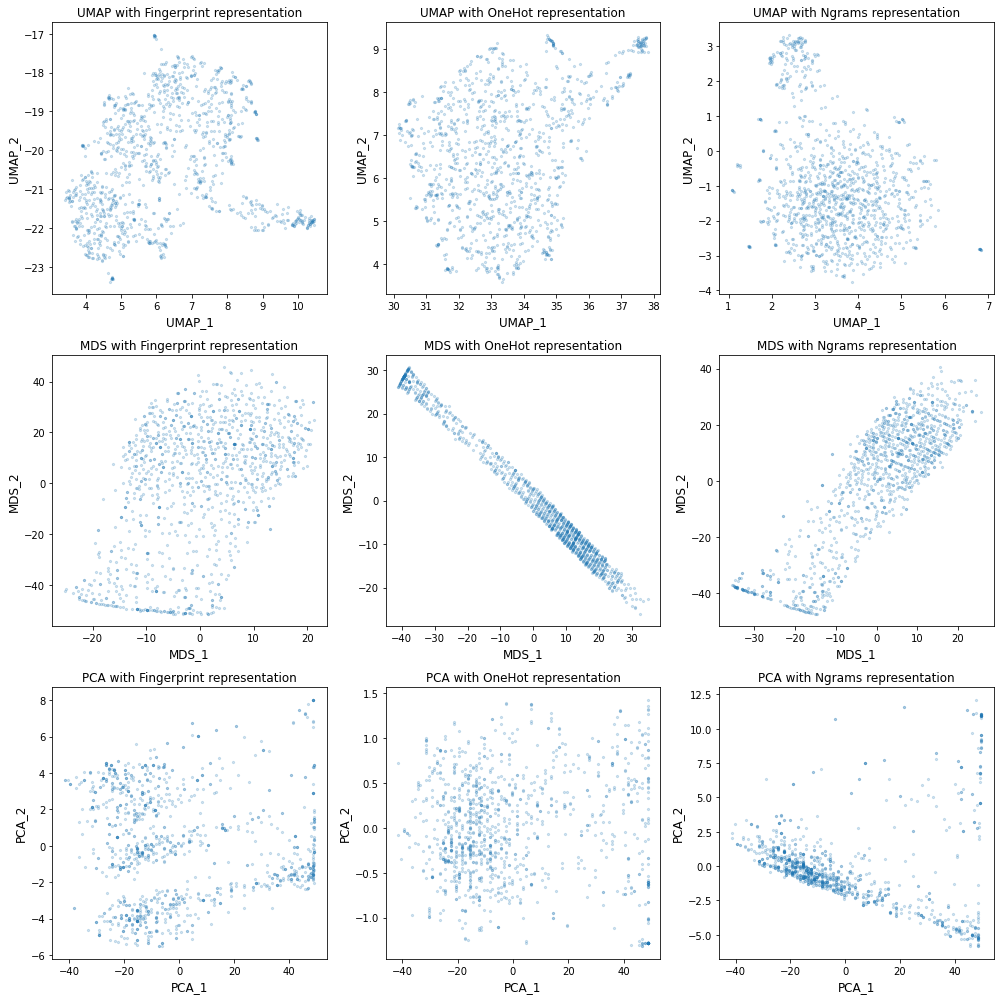

In [17]:
decomps = [umap_embedding_dict,mds_embedding_dict,pca_embedding_dict]
decomp_names = ['UMAP','MDS','PCA']
reps = ['Fingerprint','OneHot','Ngrams']

fig, axs = plt.subplots(3,3,figsize=(14,14))
for i,decomp in enumerate(decomps):
    for j,rep in enumerate(reps):
        if i == 0:  # for UMAP
            embedding = decomp[rep][2**8]
        else:
            embedding = decomp[rep]
        axs[i,j].scatter(embedding[:, 0],
                embedding[:, 1],
                s = 5,
                alpha = 0.2, 
                label = decomposition)
        axs[i,j].set_xlabel(f'{decomp_names[i]}_1', fontsize=12)
        axs[i,j].set_ylabel(f'{decomp_names[i]}_2', fontsize=12)
        axs[i,j].set_title(f'{decomp_names[i]} with {reps[j]} representation')
plt.tight_layout()

### Clustering analysis

In [18]:
epsy = 0.0931
sampley = 7
cluster_models = {
    'DBSCAN': DBSCAN(eps=epsy, min_samples=sampley),
    'AggCl': AgglomerativeClustering(n_clusters=sampley)
}

string_labels_master = {}
cluster_labels_master = {}
yhats_master = {}

for name,model in cluster_models.items():
    string_labels = {}
    cluster_labels = {}
    yhats = {}
    for i,decomp in enumerate(decomps):
        string_labels_decomp = {}
        cluster_labels_decomp = {}
        yhats_decomp = {}
        for j,rep in enumerate(reps):
            if i == 0:  # for UMAP
                embedding = decomp[rep][2**8]
            else:
                embedding = decomp[rep]
            yhat = model.fit_predict(embedding)
            clusters = np.unique(yhat)
            
            string_labels_decomp[rep] = [str(x) for x in range(1,len(clusters)+1)]
            cluster_labels_decomp[rep] = [x for x in clusters[1:]] # this will need to be 0 if there is no noise in the sample, 1 almost all other times
            yhats_decomp[rep] = yhat
        
        string_labels[decomp_names[i]] = string_labels_decomp
        cluster_labels[decomp_names[i]] = cluster_labels_decomp
        yhats[decomp_names[i]] = yhats_decomp
        
    string_labels_master[name] = string_labels
    cluster_labels_master[name] = cluster_labels
    yhats_master = yhats
    
# went a little wild with the dictionaries lmao

In [19]:
my_colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
cmap = my_colors
j = 0
while len(cmap) < len(cluster_labels) + 1:
    if j == len(my_colors):
        j = 0
    cmap.append(my_colors[j])
    j += 1

## N-grams representation

### Supervised Learning - with data normalization

In [20]:
### https://www.youtube.com/watch?v=X6pCO0-HYVE

feature_size = len(seqs)
batch_size = 16
train_size = 0.80
learning_rate = 0.01
num_epochs = 100

train_dataset = dataset.sample(frac=train_size,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

FEATURE_NAMES = train_dataset.columns

train_stats = train_dataset.describe()
train_stats.pop('Escore')
train_stats = train_stats.transpose()

NameError: name 'dataset' is not defined

In [ ]:
train_labels = train_dataset.pop('Escore')
test_labels = test_dataset.pop('Escore')

In [ ]:
class PrintDot(keras.callbacks.Callback):
    '''Displays training progress with a dot for each epoch'''
    def on_epoch_end(self,epoch,logs) -> None:
        if epoch % 100 == 0:
            print('')
        print('.',end='')
        
class PrintDot1k(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs) -> None:
        if epoch % 1000 == 0:
            print('')
        if epoch % 10 == 0:
            print('.',end='')

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        inputs[str(feature_name)] = layers.Input(
            name=str(feature_name), shape=(1,), dtype=tf.float32
        )
    return inputs

def run_experiment(model, loss, train_dataset, train_labels, test_dataset, test_labels):
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Start training the model...")
    model.fit(train_dataset, 
              batch_size = batch_size,
              epochs = num_epochs, 
              validation_data = test_dataset,
              callbacks = [PrintDot()])
    print("Model training finished.")
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")

In [ ]:
# def normalize(x: pd.DataFrame) -> pd.DataFrame:
#     return (x - train_stats['mean'])/train_stats['std']

# normed_train_data = normalize(train_dataset).fillna(0)
# normed_test_data = normalize(test_dataset).fillna(0)

normed_train_data = train_dataset.fillna(0)
normed_test_data = test_dataset.fillna(0)

train_tensor = tf.convert_to_tensor(normed_train_data)
test_tensor = tf.convert_to_tensor(normed_test_data)

train_labels_tensor = tf.convert_to_tensor(train_labels)
test_labels_tensor = tf.convert_to_tensor(test_labels)

dataset_train = tf.data.Dataset.from_tensor_slices((normed_train_data,train_labels))
dataset_test = tf.data.Dataset.from_tensor_slices((normed_test_data,test_labels))

In [ ]:
for element in dataset_train:
    print(element)

#### Probabilistic model

In [ ]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)))])
    return prior_model

# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype),
            tfp.layers.MultivariateNormalTriL(n),])
    return posterior_model

In [ ]:
def create_probablistic_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)
    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # Create a probabilisticå output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [ ]:
# train_data_tensor = tf.data.Dataset.from_tensor_slices((train_dataset,train_labels))
# test_data_tensor = tf.data.Dataset.from_tensor_slices((test_dataset,test_labels))

In [ ]:
hidden_units = [2,2]
num_epochs = 100
prob_bnn_model = create_probablistic_bnn_model(train_size)
run_experiment(prob_bnn_model, negative_loglikelihood, dataset_train, train_labels, dataset_test, test_labels)

In [ ]:
prob_bnn_model.summary()

In [ ]:
prediction_distribution = prob_bnn_model(examples)
prediction_mean = prediction_distribution.mean().numpy().tolist()
prediction_stdv = prediction_distribution.stddev().numpy()

# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()

for idx in range(sample):
    print(
        f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv[idx][0], 2)}, "
        f"95% CI: [{round(upper[idx][0], 2)} - {round(lower[idx][0], 2)}]"
        f" - Actual: {targets[idx]}"
    )

In [ ]:
def plot_history(history: tf.keras.callbacks.History) -> None:
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'],hist['mae'],label='Train Error')
    plt.plot(hist['epoch'],hist['val_mae'],label='Val Error')
    plt.legend()
    plt.show()
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'],hist['mse'],label='Train Error')
    plt.plot(hist['epoch'],hist['val_mse'],label='Val Error')
    plt.legend()
    plt.show()
    
plot_history(history)

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch
hist_df.head()

In [ ]:
model.predict(test_batch)